<a href="https://colab.research.google.com/github/rahapal/Swastha-Aalu/blob/anushka/Notebook/SwasthaAaluModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d muhammadardiputra/potato-leaf-disease-dataset

 91% 23.0M/25.2M [00:01<00:00, 30.0MB/s]
100% 25.2M/25.2M [00:01<00:00, 20.3MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/potato-leaf-disease-dataset.zip','r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from PIL import Image

from sklearn.metrics import accuracy_score , precision_score, recall_score, f1_score

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
TRAINING_DIR = os.path.join('/content/Potato/Train')
VALIDATION_DIR = os.path.join('/content/Potato/Valid')
TESTING_DIR = os.path.join('/content/Potato/Test')
#os.path.join("content",'otherdirectory","train")

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (256, 256)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(TRAINING_DIR,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 900 files belonging to 3 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(VALIDATION_DIR,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 300 files belonging to 3 classes.


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(TESTING_DIR,
                                                           shuffle=False,
                                                           labels='inferred',
                                                           label_mode='categorical',
                                                           image_size=IMG_SIZE)

Found 300 files belonging to 3 classes.


In [ ]:
class_names = train_dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

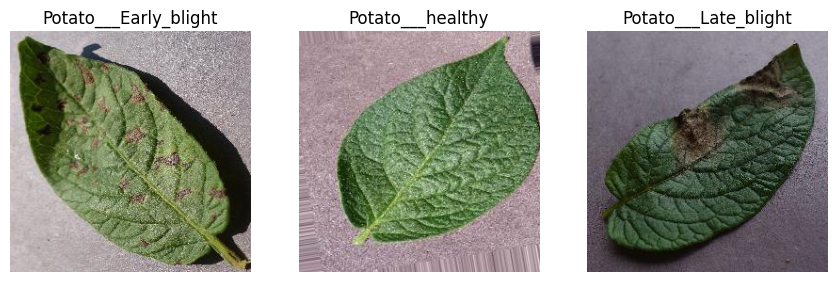

In [ ]:
classes = os.listdir('Potato/Train')

plt.figure(figsize=(18,8))

for i, class_ in enumerate(classes):
    pic = os.listdir('Potato/Train/'+ class_)[0]
    image = Image.open('Potato/Train/'+class_+'/'+pic)
    image = np.asarray(image)
    plt.subplot(2, 5, i+1)
    plt.title(class_)
    plt.imshow(image)
    plt.axis("off")
plt.show()

In [ ]:
categories = []
train = []
val= []
test = []

folders = os.listdir('Potato/Train')
for f in folders:
    categories.append(f)
    train.append(len(os.listdir(os.path.join('Potato/Train', f))))

folders = os.listdir('Potato/Valid')
for f in folders:
    val.append(len(os.listdir(os.path.join('Potato/Valid', f))))

folders = os.listdir('Potato/Test')
for f in folders:
    test.append(len(os.listdir(os.path.join('Potato/Test', f))))

data_count = pd.DataFrame({'categories': categories,
                     'train': train,
                     'val': val,
                     'test': test
                    })

data_count

,categories,train,val,test
0,Potato___Early_blight,300,100,100
1,Potato___healthy,300,100,100
2,Potato___Late_blight,300,100,100


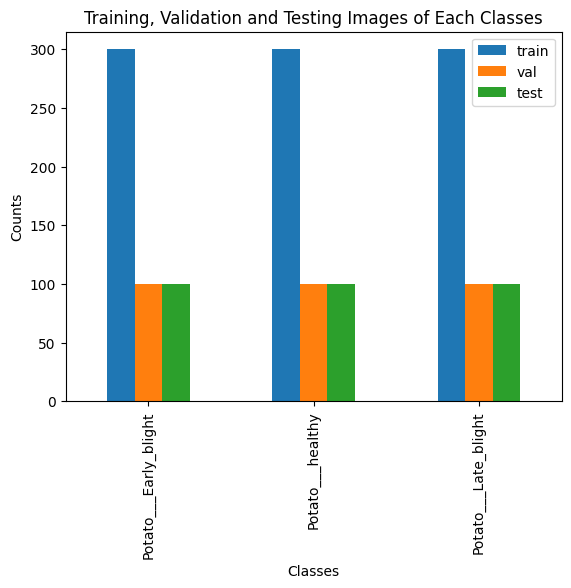

In [ ]:
data_count.plot.bar(x='categories', title="Training, Validation and Testing Images of Each Classes")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

In [ ]:
# Configure the dataset for performance
# Use buffered prefetching to load images from disk without having I/O become blocking.

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def data_augmentation(x):
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal_and_vertical'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(factor=0.2),
    ])(x)

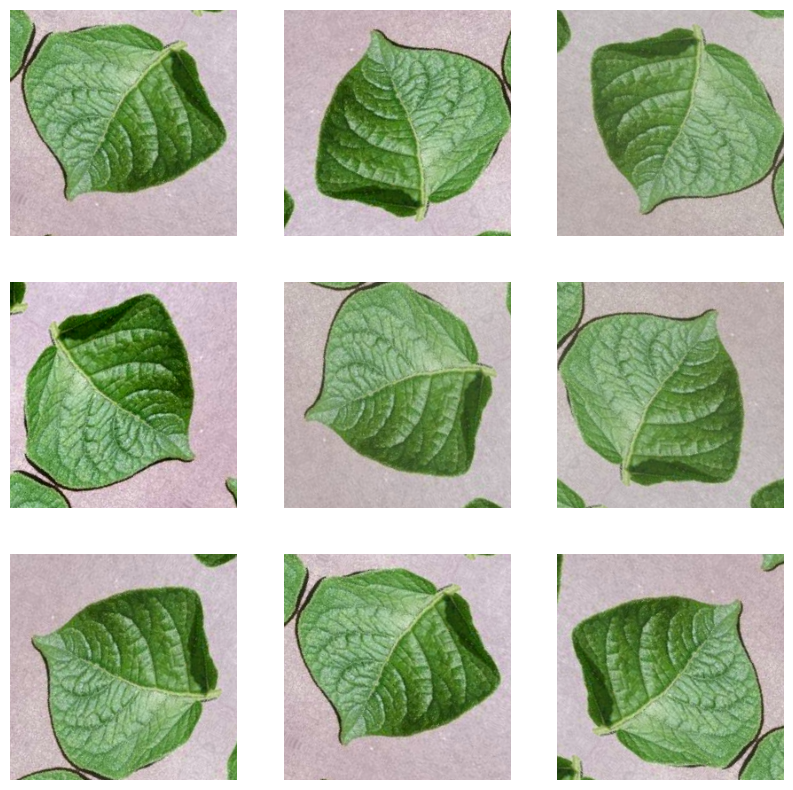

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
def preprocess_input(x):
    return tf.keras.layers.Rescaling(1./255, offset=-1)(x)


def feature_extractor(x):
    # x = tf.keras.layers.Conv2D(input_shape=(IMG_SIZE), filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Conv2D(input_shape=(IMG_SIZE), filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, padding="same")(x)

    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, padding="same")(x)

    # x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.MaxPooling2D(2, padding="same")(x)
    # x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding='same', activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    return x

def classifier(x):
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.2)(x)
    # x = tf.keras.layers.Dense(264, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.2)(x)
    return x


def prediction_layer(x):
    return tf.keras.layers.Dense(3, activation='softmax')(x)

In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = feature_extractor(x)
x = classifier(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
learning_rate = 0.001

model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                             

In [ ]:
os.path.join('/content/Potato/')
log_csv = CSVLogger('./custom_NN_logs1.csv', separator=',', append=False)
checkpoint = ModelCheckpoint('./custom_NN.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

callbacks_list = [checkpoint, early_stop, log_csv]

In [ ]:
epochs = 30

In [ ]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 1.2665 - accuracy: 0.4011
Epoch 1: val_loss improved from inf to 0.92113, saving model to ./custom_NN.hdf5
15/15 [==============================] - 18s 227ms/step - loss: 1.2665 - accuracy: 0.4011 - val_loss: 0.9211 - val_accuracy: 0.7533
Epoch 2/30
14/15 [===========================>..] - ETA: 0s - loss: 0.7957 - accuracy: 0.6596
Epoch 2: val_loss improved from 0.92113 to 0.51306, saving model to ./custom_NN.hdf5
15/15 [==============================] - 3s 138ms/step - loss: 0.7937 - accuracy: 0.6611 - val_loss: 0.5131 - val_accuracy: 0.8200
Epoch 3/30
14/15 [===========================>..] - ETA: 0s - loss: 0.5928 - accuracy: 0.7656
Epoch 3: val_loss improved from 0.51306 to 0.35969, saving model to ./custom_NN.hdf5
15/15 [==============================] - 3s 150ms/step - loss: 0.5908 - accuracy: 0.7667 - val_loss: 0.3597 - val_accuracy: 0.8800
Epoch 4/30
14/15 [===========================>..] - ETA: 0s - loss: 0.400

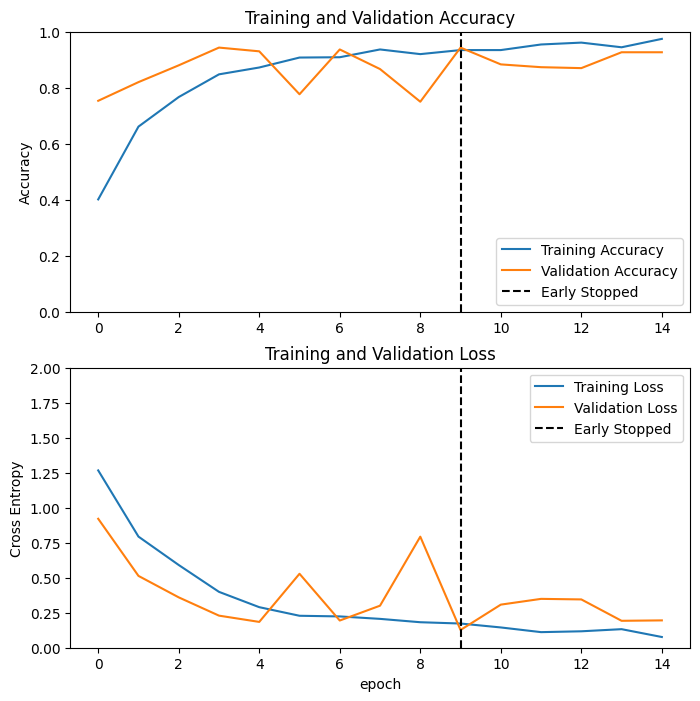

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.ylim([0.0, 1])
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([len(acc)-6, len(acc)-6], plt.ylim(),
         label='Early Stopped', linestyle='--', color='black')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.ylim([0.0, 2.0])
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([len(acc)-6, len(acc)-6], plt.ylim(),
         label='Early Stopped', linestyle='--', color='black')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
CLASSES = []

folders = os.listdir(TESTING_DIR)
for f in folders:
    CLASSES.append(f)

CLASSES

['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

In [ ]:
predictions = np.array([])
labels =  np.array([])

for x, y in test_dataset:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])


1/1 [==============================] - 0s 217ms/step


In [ ]:
# labels, predictions

Evaluating the Algorithm

Accuracy: 		 0.9233333333333333
Precision: 		 0.9312526812526812
Recall: 		 0.9233333333333333
F1 score: 		 0.9233333333333333 



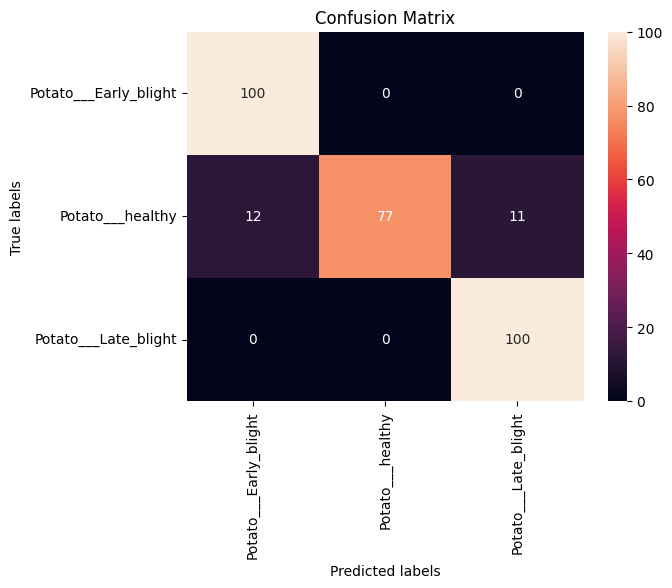

In [ ]:
print('Evaluating the Algorithm\n')
print('Accuracy: \t\t', accuracy_score(labels, predictions))
print('Precision: \t\t', precision_score(labels, predictions, average='weighted'))
print('Recall: \t\t', recall_score(labels, predictions, average='weighted'))
print('F1 score: \t\t', f1_score(labels, predictions, average='micro'), '\n')



# Confusion Matrix
cf = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()


ax= plt.subplot()
sns.heatmap(cf ,annot=True, fmt='g', ax=ax , xticklabels = CLASSES, yticklabels = CLASSES);
ax.set_title('Confusion Matrix');

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');

ax.xaxis.set_ticklabels(CLASSES);
ax.yaxis.set_ticklabels(CLASSES);

plt.xticks(rotation = 90)
plt.yticks(rotation = 360)

plt.show()

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#model.save('model.h5')

In [ ]:
#import joblib
#joblib.dump(model, '/content/model.pkl')


['/content/model.pkl']

In [ ]:
#from google.colab import files
#files.download('/content/model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#!mkdir -p saved_model
#model.save('saved_model/my_model')

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model.h5')

In [ ]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model  my_model.h5
assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [ ]:
#new_model = tf.keras.models.load_model('saved_model/my_model')



In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model.h5')



In [ ]:
#from google.colab import files
#files.download('/content/saved_model/my_model')

In [ ]:
#!tar cvfz my_model.tar.gz /content/saved_model/my_model


In [ ]:
#!tar cvf my_model.tar /content/saved_model/my_model

tar: Removing leading `/' from member names
/content/saved_model/my_model/
/content/saved_model/my_model/fingerprint.pb
/content/saved_model/my_model/assets/
/content/saved_model/my_model/keras_metadata.pb
/content/saved_model/my_model/variables/
/content/saved_model/my_model/variables/variables.data-00000-of-00001
/content/saved_model/my_model/variables/variables.index
/content/saved_model/my_model/saved_model.pb


In [ ]:
from google.colab import files

files.download('saved_model/my_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


print(tf.__version__)


2.12.0
